In [1]:
%load_ext autoreload
%autoreload 2
import bert
import samples
import sklearn.mixture
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as  plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from utils import *
import pdb
import umap
import hdbscan


from numpy import dot
from numpy.linalg import norm
from sklearn.metrics import silhouette_score


In [2]:
# Data loading
years = ["2018", "2019", "2022"]
nips_df = pd.read_csv(f"nips_{years[0]}_clean2.csv")
embeddings = load_embeddings(f"outputs/clean2_nips_{years[0]}_embeddings.pkl")
for year in years[1:]:
    current_df = pd.read_csv(f"nips_{year}_clean2.csv")
    nips_df = pd.concat([nips_df, current_df], ignore_index=True)
    del current_df
    current_embeddings = load_embeddings(f"outputs/clean2_nips_{year}_embeddings.pkl")
    embeddings = np.append(embeddings, current_embeddings, axis=0)
    del current_embeddings
    
nips_df

,Unnamed: 0,title,authors,abstract,year
0,0,Synthesized Policies for Transfer and Adaptati...,"Hexiang Hu, Liyu Chen, Boqing Gong, Fei Sha",The ability to transfer in reinforcement learn...,2018
1,1,Self-Supervised Generation of Spatial Audio fo...,"Pedro Morgado, Nuno Nvasconcelos, Timothy Lang...",We introduce an approach to convert mono audio...,2018
2,2,On GANs and GMMs,"Eitan Richardson, Yair Weiss",A longstanding problem in machine learning is ...,2018
3,3,Batch-Instance Normalization for Adaptively St...,"Hyeonseob Nam, Hyo-Eun Kim",Real-world image recognition is often challeng...,2018
4,4,Hierarchical Reinforcement Learning for Zero-s...,"Sungryull Sohn, Junhyuk Oh, Honglak Lee",We introduce a new RL problem where the agent ...,2018
...,...,...,...,...,...
4502,2619,Cost-efficient Gaussian tensor network embeddi...,"Linjian Ma, Edgar Solomonik","This work discusses tensor network embeddings,...",2022
4503,2620,Neural Transmitted Radiance Fields,"Chengxuan Zhu, Renjie Wan, Boxin Shi",Neural radiance fields (NeRF) have brought tre...,2022
4504,2622,Structural Kernel Search via Bayesian Optimiza...,"Matthias Bitzer, Mona Meister, Christoph Zimmer",Despite recent advances in automated machine l...,2022
4505,2623,Near-Optimal No-Regret Learning Dynamics for G...,"Gabriele Farina, Ioannis Anagnostides, Haipeng...",A recent line of work has established un...,2022


In [3]:
embeddings.shape

(4507, 768)

In [4]:
nips_df

,Unnamed: 0,title,authors,abstract,year
0,0,Synthesized Policies for Transfer and Adaptati...,"Hexiang Hu, Liyu Chen, Boqing Gong, Fei Sha",The ability to transfer in reinforcement learn...,2018
1,1,Self-Supervised Generation of Spatial Audio fo...,"Pedro Morgado, Nuno Nvasconcelos, Timothy Lang...",We introduce an approach to convert mono audio...,2018
2,2,On GANs and GMMs,"Eitan Richardson, Yair Weiss",A longstanding problem in machine learning is ...,2018
3,3,Batch-Instance Normalization for Adaptively St...,"Hyeonseob Nam, Hyo-Eun Kim",Real-world image recognition is often challeng...,2018
4,4,Hierarchical Reinforcement Learning for Zero-s...,"Sungryull Sohn, Junhyuk Oh, Honglak Lee",We introduce a new RL problem where the agent ...,2018
...,...,...,...,...,...
4502,2619,Cost-efficient Gaussian tensor network embeddi...,"Linjian Ma, Edgar Solomonik","This work discusses tensor network embeddings,...",2022
4503,2620,Neural Transmitted Radiance Fields,"Chengxuan Zhu, Renjie Wan, Boxin Shi",Neural radiance fields (NeRF) have brought tre...,2022
4504,2622,Structural Kernel Search via Bayesian Optimiza...,"Matthias Bitzer, Mona Meister, Christoph Zimmer",Despite recent advances in automated machine l...,2022
4505,2623,Near-Optimal No-Regret Learning Dynamics for G...,"Gabriele Farina, Ioannis Anagnostides, Haipeng...",A recent line of work has established un...,2022


In [23]:
# reduce dimensions to 5 using umap
# reduced_embeddings = reduce_dim(embeddings, "umap", 5)
reduced_embeddings = embeddings
# cluster
cluster_algorithm = "gmm" # dbscan/gmm

clusters, model = cluster_and_predict(reduced_embeddings, cluster_algorithm, num_cluster=10)
# saving_path = "outputs/dim_200"
# os.makedirs(saving_path, exist_ok=True)
# models, losses = train_cluster(reduced_embeddings, cluster_algorithm, "sil", range(2, 40, 3), saving_path=saving_path)

In [6]:
losses

{2: 0.41818094,
 5: 0.21022962,
 8: 0.13922161,
 11: 0.15819956,
 14: 0.15214705,
 17: 0.1302445,
 20: 0.14268798,
 23: 0.1405234,
 26: 0.14543615,
 29: 0.16281718,
 32: 0.15825057,
 35: 0.14562236,
 38: 0.13909854}

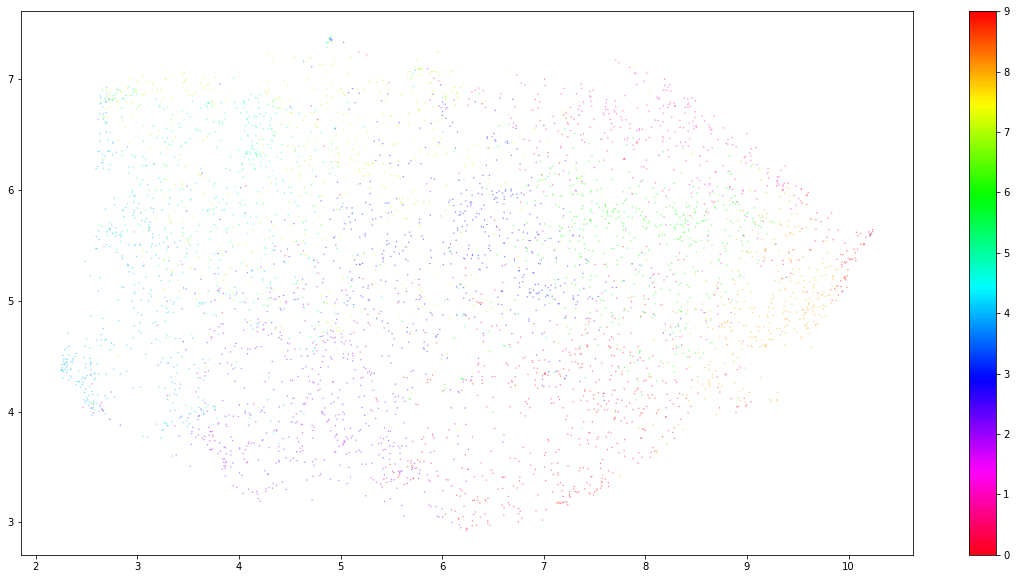

In [24]:
if cluster_algorithm == "gmm":
    paper_labels = clusters
elif cluster_algorithm == "dbscan":
    paper_labels = clusters.labels_

# for dbscan
# visualize(embeddings, clusters.labels_)

# for gmm
visualize(embeddings, paper_labels)


In [25]:
dic = {}
# for dbscan
# dic = metrics(["sil"], reduced_embeddings, clusters.labels_, dic)

# for gmm
dic = metrics(["sil"], reduced_embeddings, paper_labels, dic)

print(dic)

{'sil': 0.026253853}


In [26]:
nips_df, docs_per_topic = create_docs_per_topic(nips_df, paper_labels)

tf_idf, count = c_tf_idf(docs_per_topic.abstract.values, m=len(nips_df))

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(nips_df); topic_sizes.head(10)

c:\Users\echen\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
7,7,597
0,0,573
2,2,573
3,3,529
6,6,516
5,5,480
4,4,417
8,8,372
1,1,349
9,9,101


In [27]:
print(topic_sizes)

   Topic  Size
7      7   597
0      0   573
2      2   573
3      3   529
6      6   516
5      5   480
4      4   417
8      8   372
1      1   349
9      9   101


In [37]:
top_n_words[9][:10]

[('study', 0.03690371714063668),
 ('convex', 0.02322888474498822),
 ('consider', 0.022819308035511476),
 ('given', 0.01727737882811267),
 ('problem', 0.01552749351824847),
 ('stochastic', 0.015456004060904366),
 ('norm', 0.014580717796869147),
 ('bound', 0.012541517567716902),
 ('distance', 0.012459312580189919),
 ('lower', 0.012307553094371886)]

In [8]:
top_n_words[5][:10]

[('3d', 0.02896285069661077),
 ('scene', 0.018290884614085103),
 ('camera', 0.015491176163946485),
 ('images', 0.015206925348009537),
 ('reconstruction', 0.014732394333896996),
 ('poses', 0.014654538438119721),
 ('pose', 0.014516650812357281),
 ('scenes', 0.013544405490856537),
 ('image', 0.013420081816518829),
 ('deformation', 0.012702113958092084)]